In [1]:
from pathlib import Path
import numpy as np
import torch

TRAIN_FILEPATH = "/Users/33783/Desktop/capgemini/hackathon-mines-invent-2024/DATA/TRAIN"
TEST_FILEPATH = "/Users/33783/Desktop/capgemini/hackathon-mines-invent-2024/DATA/TEST"

TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
TRAIN_RATIO = 0.1

In [2]:
from baseline.dataset import (BaselineDataset, 
                              BaselineDatatest,
                              get_train_val_Dataloaders,
                              get_test_Dataloader,
                              )

data_train_folder = Path(TRAIN_FILEPATH)
data_test_folder = Path(TEST_FILEPATH)

dt_train = BaselineDataset(Path(data_train_folder))
dt_test = BaselineDatatest(Path(data_test_folder))

train_loader, val_loader = get_train_val_Dataloaders(
    dt_train,
    train_ratio=TRAIN_RATIO,
    train_batch_size=TRAIN_BATCH_SIZE,
    val_batch_size=VAL_BATCH_SIZE,
)

x_train, y_train = train_loader.__iter__().__next__()
x_val, y_val = val_loader.__iter__().__next__()

for k, v in x_train.items():
    print(k,v.shape)
print("y", y_train.shape)

test_loader = get_test_Dataloader(
    dt_test, test_batch_size=TEST_BATCH_SIZE)
x_test = test_loader.__iter__().__next__()

for k, v in x_test.items():
    print(k,v.shape)

Reading patch metadata ...
Done.
Dataset ready.
Reading patch metadata ...
Done.
Dataset ready.
S2 torch.Size([8, 61, 10, 128, 128])
date torch.Size([8, 61, 5])
TILE torch.Size([8, 1])
N_Parcel torch.Size([8, 1])
Parcel_Cover torch.Size([8, 1])
y torch.Size([8, 128, 128])
S2 torch.Size([8, 43, 10, 128, 128])
date torch.Size([8, 43, 5])
TILE torch.Size([8, 1])
N_Parcel torch.Size([8, 1])
Parcel_Cover torch.Size([8, 1])


In [3]:
def preprocess_month_median(input_batch):
    """
    Here we want to use the collapse the temporal dimension of the input
    batch by keeping the median value for each pixel for each month
    going from [batch_size, T, 10, 128, 128]
    to [batch_size, 11, 8, 128, 128]
    (we select only 8 channels to match model architecture (needs power of 2))
    (We don't do december since not all samples have an image for this month)

    We also return a batch of vectors of size 3 
    that contains TILE, N_Parcel and Parcel_Cover info

    input_batch: dataloader X dict batch
    """
    batch_len = input_batch["date"].shape[0]

    batch_embeds = []
    batch_vectors = []
    for i in range(batch_len):
        median_imgs = []
        for month in range(1, 12):
            month_locs = []
            month_locs = torch.where(input_batch["date"][i,:,1] == month)[0]
            
            median = torch.median(input_batch["S2"][i,month_locs,:8], dim=0, keepdim=False)
            median_imgs.append(median[0])
            sample_embed = torch.stack(median_imgs, dim=0)
        batch_embeds.append(sample_embed)

    batch_vectors =torch.cat([input_batch["TILE"],
                              input_batch["N_Parcel"],
                              input_batch["Parcel_Cover"]], dim=1).to(torch.float32)
    
    return torch.stack(batch_embeds, dim=0), batch_vectors

In [4]:
from sklearn.metrics import jaccard_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

from unet_3d.model import UNet3D
from torch.optim import Adam
import math

MODEL_PATH = Path("models") / 'unet3d.pth'
LOAD_MODEL = True
IMG_HEIGHT = 128  
IMG_WIDTH = 128  
LEARNING_RATE = 0.0005
EPOCHS = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
CLASS_WEIGHTS = torch.Tensor([0.0090, 0.0135, 0.0218, 0.0195, 0.0399, 0.0427, 0.0701, 0.0569, 0.0335,
        0.0618, 0.0688, 0.0551, 0.0585, 0.1052, 0.0449, 0.0566, 0.0582, 0.0791,
        0.0867, 0.0183]).to(device)

model = UNet3D(in_add_features=3, in_channels=11 , num_classes= 20).to(device).train()
criterion = CrossEntropyLoss(weight=CLASS_WEIGHTS)
optimizer = Adam(params=model.parameters(), lr=LEARNING_RATE)

min_valid_loss = math.inf

for epoch in range(EPOCHS):
    
    train_loss = 0.0
    model.train()
    for i, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, inputs_vector = preprocess_month_median(inputs)
        targets = targets.unsqueeze(1).expand(-1, 8, -1,-1)
        inputs, inputs_vector, targets = inputs.to(device), inputs_vector.to(device), targets.to(device)
        
        outputs = model(inputs, inputs_vector)
        loss = criterion(outputs, targets.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    model.eval()
    for i, (inputs, targets) in tqdm(enumerate(val_loader), total=len(val_loader)):
        inputs, inputs_vector = preprocess_month_median(inputs)
        inputs, inputs_vector, targets = inputs.to(device), inputs_vector.to(device), targets.to(device)
        
        outputs = model(inputs, inputs_vector)
        loss = criterion(outputs,targets.long())
        valid_loss = loss.item()
    
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), f'models/unet3d_epoch{epoch}_valLoss{min_valid_loss}.pth')


  0%|          | 0/25 [00:00<?, ?it/s]c:\Users\33783\miniconda3\envs\env_challenge\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  8%|▊         | 2/25 [05:05<58:28, 152.54s/it]


KeyboardInterrupt: 

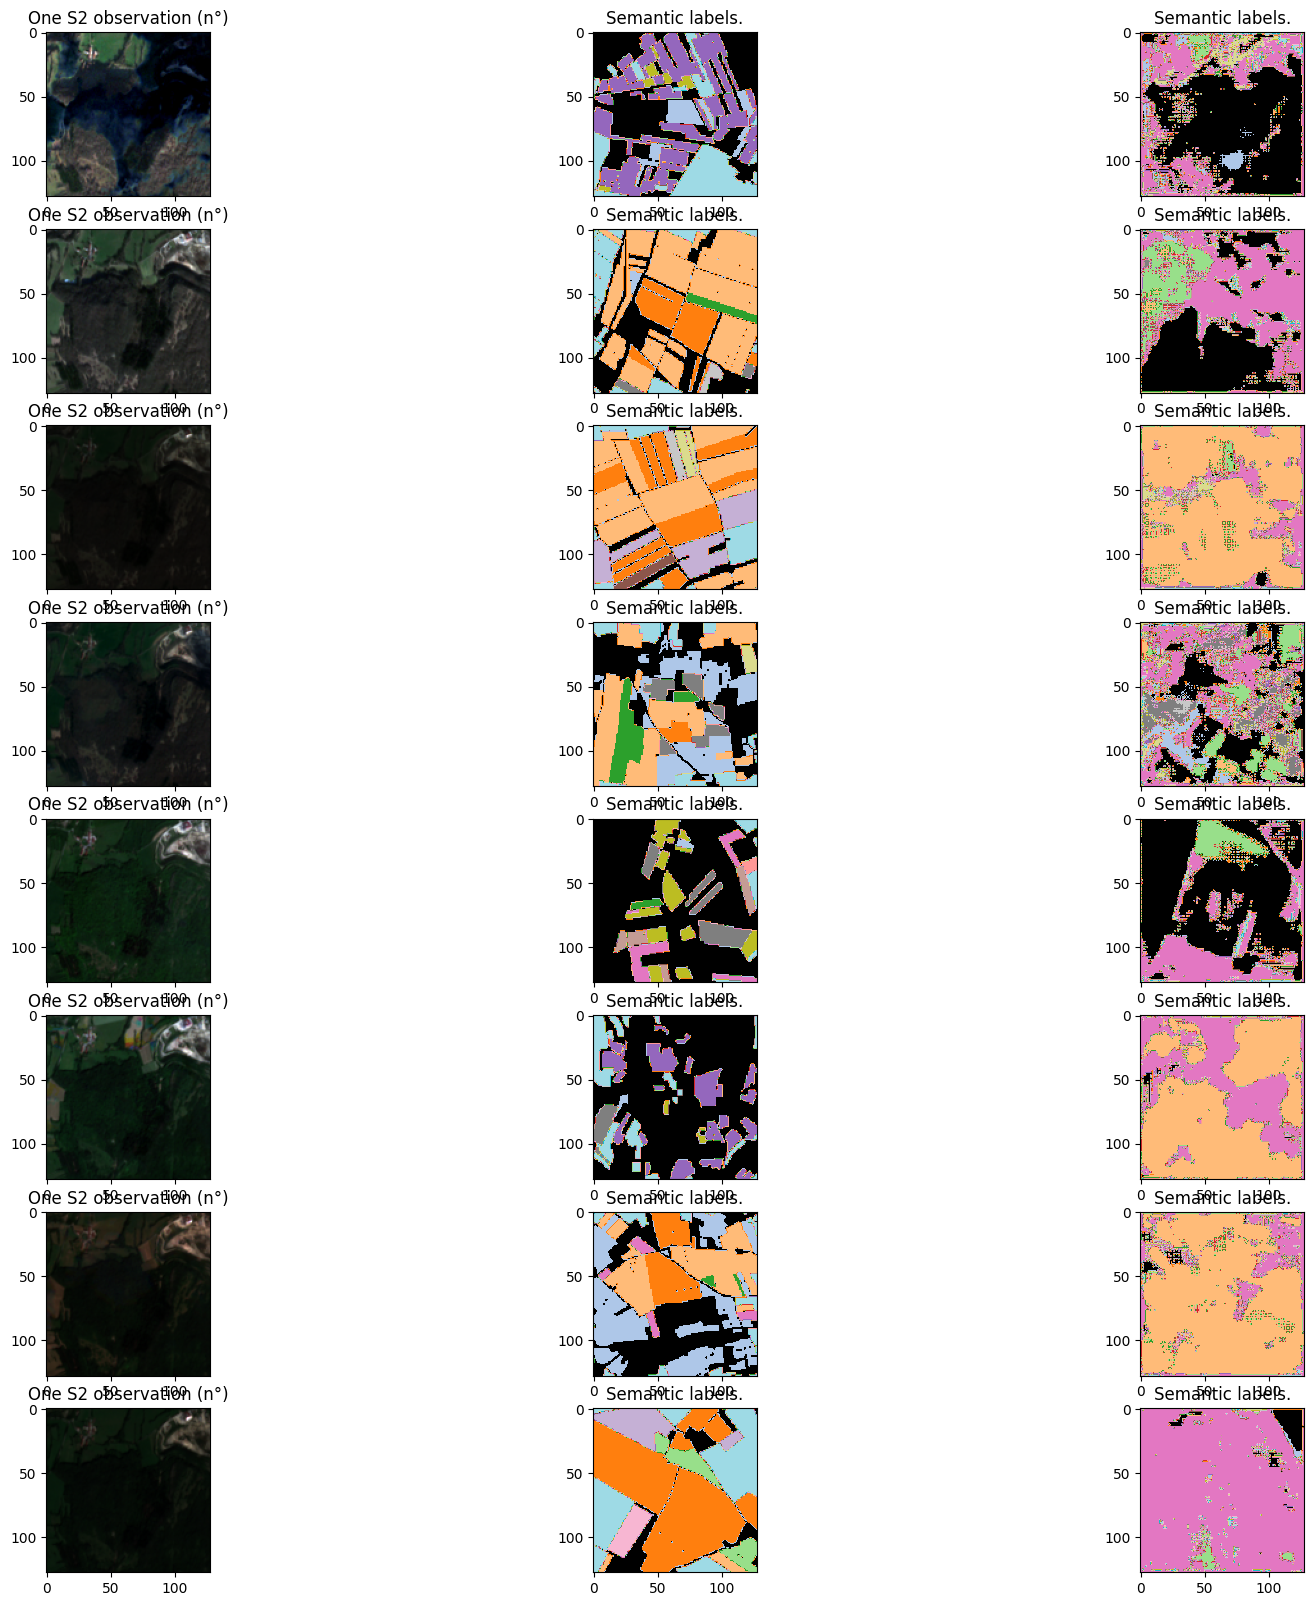

In [15]:
from baseline.viz import plot_s2_and_labels, get_rgb
from matplotlib.colors import ListedColormap
import matplotlib
import matplotlib.pyplot as plt

cm = matplotlib.colormaps.get_cmap("tab20")
def_colors = cm.colors
cus_colors = ["k"] + [def_colors[i] for i in range(1, 20)] + ["w"]
cmap = ListedColormap(colors=cus_colors, name="agri", N=21)

#x_train, y_train = train_loader.__iter__().__next__()
#input_preprocessed = preprocess_batch_august(x_train)

x_val, y_val = val_loader.__iter__().__next__()
input_preprocessed, input_vectors = preprocess_month_median(x_val)

def get_preds_from_raw_out(raw_out):
    return raw_out.max(dim=2).values.argmax(dim=1)

preds = model(input_preprocessed.to(device), input_vectors.to(device))
preds = get_preds_from_raw_out(preds).cpu().numpy()

# Create subplots
fig, axes = plt.subplots(8, 3, figsize=(20, 20))

for bid in range(8):
    im = input_preprocessed[0][bid, [2, 1, 0]].cpu().numpy()
    mx = im.max(axis=(1, 2))
    mi = im.min(axis=(1, 2))
    im = (im - mi[:, None, None]) / (mx - mi)[:, None, None]
    im = im.swapaxes(0, 2).swapaxes(0, 1)
    im = np.clip(im, a_max=1, a_min=0)

    # Plot the Sentinel-2 RGB image
    axes[bid, 0].imshow(im)
    axes[bid, 0].set_title(f"One S2 observation (n°)")
 
    # Plobid, t the semantic labels
    axes[bid, 1].imshow(y_train[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)
    axes[bid, 1].set_title("Semantic labels.")
 
    axes[bid, 2].imshow(preds[bid], cmap=cmap, vmin=0, vmax=20)
    axes[bid, 2].set_title("Semantic labels.")

# Show the plot
plt.show()

In [6]:
from sklearn.metrics import jaccard_score

def print_iou_per_class(
    targets: torch.Tensor,
    preds: torch.Tensor,
    nb_classes: int,
) -> None:
    """
    Compute IoU between predictions and targets, for each class.

    Args:
        targets (torch.Tensor): Ground truth of shape (B, H, W).
        preds (torch.Tensor): Model predictions of shape (B, nb_classes, H, W).
        nb_classes (int): Number of classes in the segmentation task.
    """

    # Compute IoU for each class
    # Note: I use this for loop to iterate also on classes not in the demo batch

    iou_per_class = []
    for class_id in range(nb_classes):
        iou = jaccard_score(
            targets == class_id,
            preds == class_id,
            average="binary",
            zero_division=0,
        )
        iou_per_class.append(iou)

    for class_id, iou in enumerate(iou_per_class):
        print(
            "class {} - IoU: {:.4f} - targets: {} - preds: {}".format(
                class_id, iou, (targets == class_id).sum(), (preds == class_id).sum()
            )
        )

def print_mean_iou(targets: torch.Tensor, preds: torch.Tensor) -> None:
    """
    Compute mean IoU between predictions and targets.

    Args:
        targets (torch.Tensor): Ground truth of shape (B, H, W).
        preds (torch.Tensor): Model predictions of shape (B, nb_classes, H, W).
    """

    mean_iou = jaccard_score(targets, preds, average="macro")
    print(f"meanIOU (over existing classes in targets): {mean_iou:.4f}")

In [18]:
score = 0.
for i, (inputs, targets) in tqdm(enumerate(val_loader)):
    inputs, inputs_vector = preprocess_month_median(inputs)
    inputs, inputs_vector, targets = inputs.to(device), inputs_vector.to(device), targets.to(device)
    outputs = model(inputs, inputs_vector)
    preds = get_preds_from_raw_out(outputs)
    preds = preds.cpu().numpy().flatten()
    targets = targets.cpu().numpy().flatten()
    score +=jaccard_score(targets, preds, average="macro")

print(f"meanIOU (over existing classes in targets): {score / len(val_loader)}")

1it [00:05,  5.06s/it]

In [ ]:
#frequency calculations to weight loss
total_counts = {}

# Iterate over DataLoader batches
for batch in train_loader:
    batch_data = batch[1]  # Extract data from the batch
    unique_values, batch_counts = torch.unique(batch_data, return_counts=True)

    # Accumulate counts in the dictionary
    for value, count in zip(unique_values, batch_counts):
        value = value.item()
        if value in total_counts:
            total_counts[value] += count.item()
        else:
            total_counts[value] = count.item()
            torch.unique(y_train, return_counts=True)



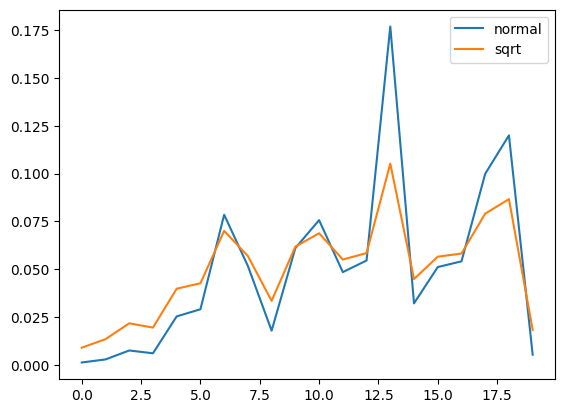

In [20]:
frequencies_sqrt = torch.zeros(20)
frequencies = torch.zeros(20)
for k, v in total_counts.items():
    frequencies_sqrt[k] = np.sqrt(v)
    frequencies[k] = v
frequencies_sqrt = frequencies_sqrt/torch.sum(frequencies_sqrt)
frequencies = frequencies/torch.sum(frequencies)

weights = 1/frequencies
weights = weights/torch.sum(weights)
weights_sqrt = 1/frequencies_sqrt
weights_sqrt = weights_sqrt/torch.sum(weights_sqrt)

import matplotlib.pyplot as plt

plt.plot(weights, label="normal")
plt.plot(weights_sqrt, label="sqrt")
plt.legend()